<a href="https://colab.research.google.com/github/dtoralg/IE_Calidad_ML/blob/main/Ejercicios/Modulo%204/Modulo_4_Ejercicio_2_Clasificacion_Desbalanceada_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Ejercicio 2: Evaluación de Métricas en un Problema de Clasificación Desbalanceado**
#### Análisis del impacto del desbalance de clases y aplicación de técnicas de balanceo en la predicción de fallas en sensores industriales

### **Introducción**
En este ejercicio, exploraremos cómo el **desbalance de clases** afecta la evaluación de un modelo de clasificación binaria y aplicaremos técnicas para manejar este problema.

El dataset utilizado contiene información sobre sensores industriales, con un 95% de sensores funcionales y solo un 5% de fallas. Este desbalance puede afectar la capacidad del modelo para detectar correctamente los sensores defectuosos.

Evaluaremos el modelo utilizando **Precisión, Recall, F1 Score y Curva ROC-AUC** antes y después de aplicar **SMOTE** para balancear las clases.

In [ ]:
# Celda 1: Carga de librerías y configuración del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Configuración de gráficos
sns.set(style='whitegrid')

In [ ]:
# Celda 2: Carga del dataset
dataset_path = 'https://github.com/dtoralg/IE_Calidad_ML/raw/main/Data/fallas_sensores.csv'
data = pd.read_csv(dataset_path)

# Mostrar las primeras filas del dataset
data.head()

,ID_sensor,Temperatura_operacion,Vibracion,Humedad,Presion,Corriente_electrica,Frecuencia_medicion,Tiempo_operacion,Tipo_sensor,Falla
0,1,82.450712,4.545892,49.020365,2.304435,12.147258,23,1186,Inductivo,No
1,2,72.926035,1.266968,66.237516,3.477414,9.729300,34,739,Capacitivo,No
2,3,84.715328,3.863156,79.323942,4.445244,10.133768,5,523,Inductivo,No
3,4,97.845448,2.071142,76.814784,2.182518,8.097643,59,1541,Inductivo,No
4,5,71.487699,2.508896,41.398791,1.409142,10.310082,12,1371,Capacitivo,No


In [ ]:
# Celda 3: Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_sensor              100000 non-null  int64  
 1   Temperatura_operacion  100000 non-null  float64
 2   Vibracion              100000 non-null  float64
 3   Humedad                100000 non-null  float64
 4   Presion                100000 non-null  float64
 5   Corriente_electrica    100000 non-null  float64
 6   Frecuencia_medicion    100000 non-null  int64  
 7   Tiempo_operacion       100000 non-null  int64  
 8   Tipo_sensor            100000 non-null  object 
 9   Falla                  100000 non-null  object 
dtypes: float64(5), int64(3), object(2)
memory usage: 7.6+ MB


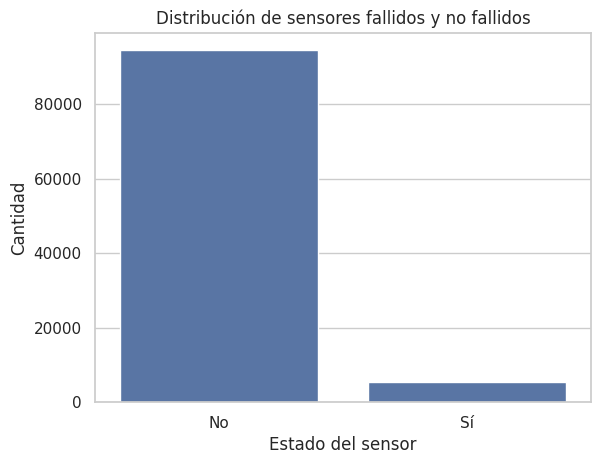

In [ ]:
# Celda 4: Distribución de la variable objetivo
sns.countplot(x='Falla', data=data)
plt.title('Distribución de sensores fallidos y no fallidos')
plt.xlabel('Estado del sensor')
plt.ylabel('Cantidad')
plt.show()

### **Preprocesamiento de los datos**
Se realizará un proceso estándar de preparación de datos que incluye:
- Eliminación de duplicados.
- Imputación de valores faltantes.
- Codificación de variables categóricas.
- Normalización de variables numéricas.

In [ ]:
# Celda 5: Procesamiento de datos
# Eliminar duplicados
data = data.drop_duplicates()

# Imputar valores faltantes con la mediana para variables numéricas
numeric_features = ['Temperatura_operacion', 'Vibracion', 'Humedad', 'Presion', 'Corriente_electrica', 'Frecuencia_medicion', 'Tiempo_operacion']
imputer = SimpleImputer(strategy='median')
data[numeric_features] = imputer.fit_transform(data[numeric_features])

# Codificar variables categóricas con OneHotEncoder
categorical_features = ['Tipo_sensor']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Codificar la variable objetivo (No=0, Sí=1)
data['Falla'] = data['Falla'].map({'No': 0, 'Sí': 1})

# División en variables predictoras y objetivo
X = data.drop(columns=['Falla'])
y = data['Falla']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalización de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Entrenamiento del modelo sin balanceo**
Se entrenará un modelo de **Random Forest** en el dataset original para analizar el impacto del desbalance de clases.

In [ ]:
# Celda 6: Entrenamiento del modelo de Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_test)

In [ ]:
# Celda 7: Evaluación del modelo sin balanceo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18898
           1       0.00      0.00      0.00      1102

    accuracy                           0.94     20000
   macro avg       0.47      0.50      0.49     20000
weighted avg       0.89      0.94      0.92     20000



### **Aplicación de SMOTE para balancear las clases**
El dataset original está desbalanceado, por lo que aplicaremos **SMOTE** para generar nuevas muestras sintéticas de la clase minoritaria y entrenaremos el modelo nuevamente.

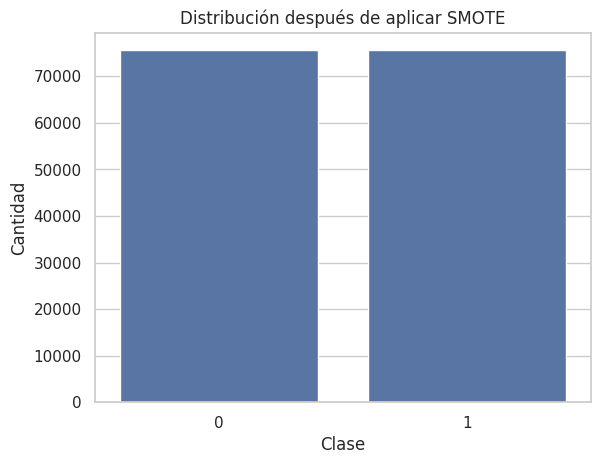

In [ ]:
# Celda 8: Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la nueva distribución de clases
sns.countplot(x=y_train_resampled)
plt.title('Distribución después de aplicar SMOTE')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
# Celda 9: Entrenar modelo con datos balanceados
modelo_smote = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_smote.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_smote = modelo_smote.predict(X_test)

In [ ]:
# Celda 10: Evaluación del modelo balanceado
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     18898
           1       0.17      0.11      0.14      1102

    accuracy                           0.92     20000
   macro avg       0.56      0.54      0.55     20000
weighted avg       0.91      0.92      0.91     20000



### **Conclusiones**
- Se compararon dos modelos: uno con datos desbalanceados y otro con **SMOTE**. El modelo balanceado mostró mejoras en **Recall y F1 Score**, indicando una mejor detección de fallos reales.
- **La Curva ROC y el AUC** permiten evaluar la capacidad del modelo para distinguir entre clases.
- **Próximos pasos:** Ajustar hiperparámetros del modelo o probar modelos más avanzados como **XGBoost**.